In [19]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib

from geopy.geocoders import Nominatim
from shapely.geometry import Point

from shortest_path import ShortestPath

In [20]:
# Initialize addresses
address_list1 = [
    "1000 Olin Way, Needham, MA",
    "958 Highland Ave, Needham, MA",
    "Medford, MA",
]

address_list2 = [
    '320 D St, Boston, MA',
    '11 Dorchester St, Boston, MA'
]

address_list = address_list1 # Switch to address_list1 or any others for new set of nodes

# Create ShortestPath object and initialize graph
alg = ShortestPath(address_list, 1000)
start = address_list[0]
end = address_list[1]

start_id = alg.nearest_node(start)
end_id = alg.nearest_node(end)

Converting addresses...
Adding '1000 Olin Way, Needham, MA' to dictionary.
Adding '958 Highland Ave, Needham, MA' to dictionary.
Adding 'Medford, MA' to dictionary.
Creating graph...
MultiDiGraph with 87 nodes and 223 edges
Graph created & setup complete.


In [21]:
# Find max flow from start to end and add flow to graph attributes
max_flow, flowDict = alg.max_flow_path(start, end)
actual_flow = ox.graph_to_gdfs(alg.graph, nodes=False)['actual_flow'].fillna(0)
nx.set_edge_attributes(alg.graph, actual_flow, 'actual_flow')
print("Max flow possible: ", max_flow)

# Find min cut edges (bottleneck)
cut_value, partition, cutset = alg.min_cut(start, end)
print("Min cut (should match max flow): ", cut_value)
print("Edges making min cut: ", cutset)

Max flow possible:  1900.0
Min cut (should match max flow):  1900.0
Edges making min cut:  {(6, 67)}


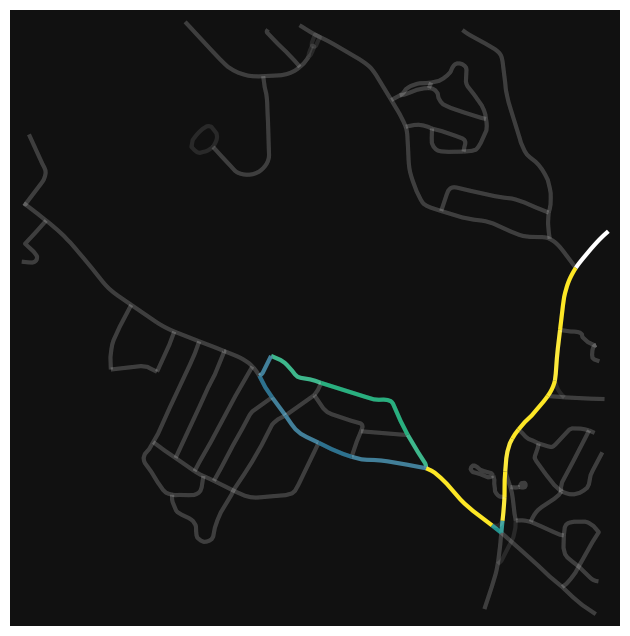

In [22]:
# Map actual flow to color gradient
colors = ox.plot.get_edge_colors_by_attr(alg.graph, attr="actual_flow", cmap="viridis")

edge_has_flow = []

# Create list of 0/1 representing if that edge has flow or not
for u, v, ind in alg.graph.edges:
    if u == 121:
        print(u, v)
    if (u, v) in cutset:
        edge_has_flow.append(2)
    elif alg.graph[u][v][ind]['actual_flow'] == 0.0:
        edge_has_flow.append(1)
    else:
        edge_has_flow.append(0)

# Edit color so that 0.0 flow maps to translucent white, not the purple from viridis's 0
# Min cut values currently map to (1, 1, 1, 1) and are very bright. Comment out this section
# And uncomment the next one to ignore mincut for the graph
for index, value in colors.items():
    if edge_has_flow[0] == 1:
        colors[index] = (1, 1, 1, 0.1)
    elif edge_has_flow[0] == 2:
        colors[index] = (1, 1, 1, 1)
    edge_has_flow.pop(0)

# Uncomment this section and comment the above one to ignore mincut
# for index, value in colors.items():
#     if edge_has_flow[0] == 1:
#         colors[index] = (1, 1, 1, 0.1)
#     edge_has_flow.pop(0)

# Plot max flow path with color gradient and save image
fig, ax = ox.plot_graph(alg.graph, node_size=0, edge_linewidth =3, edge_color=colors)
fig.colorbar(matplotlib.cm.ScalarMappable(cmap="viridis"), ax=ax)
fig.savefig("MaxFlow.png")

Max Flow Dijkstra (Time):  700.0


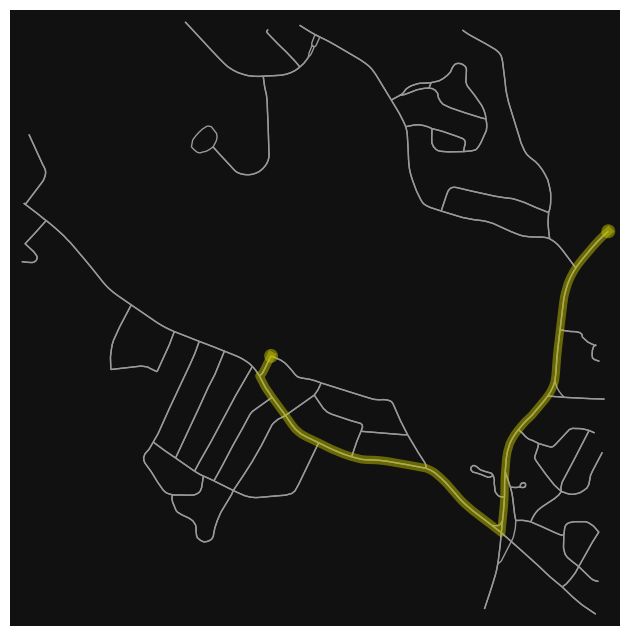

In [7]:
# OSMnx Dijkstra's by Travel Time
dijkstra_shortest_path_list_time = alg.d_shortest_path(address_list[0], address_list[1], weight="travel_time")

# Max flow for shortest path is the bottleneck capacity
max_flow_djkstra = 1900
for u, v, ind in alg.graph.edges:
    if alg.graph[u][v][ind]["actual_flow"] > 0.00:
        if alg.graph[u][v][ind]["actual_flow"] < max_flow_djkstra:
            max_flow_djkstra = alg.graph[u][v][ind]["actual_flow"]
print("Max Flow Dijkstra (Time): ", max_flow_djkstra)

fig, ax = ox.plot_graph_route(alg.graph, dijkstra_shortest_path_list_time, route_color="y", route_linewidth=6, node_size=0)

Max Flow Dijkstra (Distance):  700.0


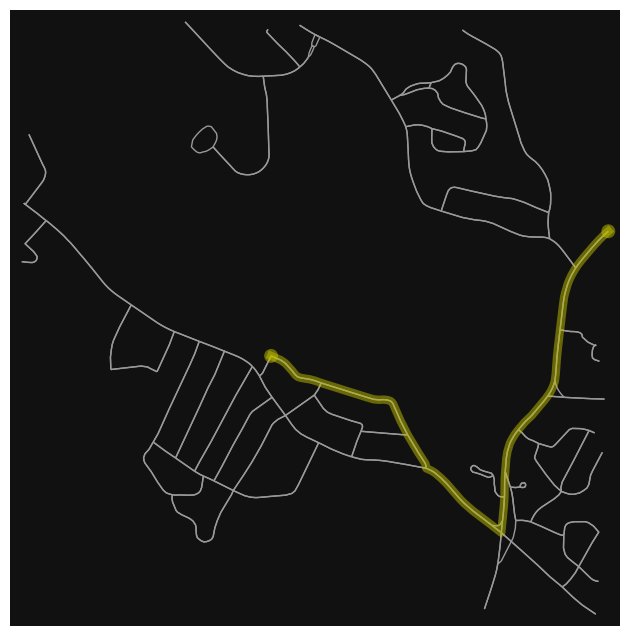

In [8]:
# OSMnx Dijkstra's by Distance
dijkstra_shortest_path_list_distance = alg.d_shortest_path(address_list[0], address_list[1], weight="length")

# Max flow for shortest path is the bottleneck capacity
max_flow_djkstra = 1900
for u, v, ind in alg.graph.edges:
    if alg.graph[u][v][ind]["actual_flow"] > 0.00:
        if alg.graph[u][v][ind]["actual_flow"] < max_flow_djkstra:
            max_flow_djkstra = alg.graph[u][v][ind]["actual_flow"]
print("Max Flow Dijkstra (Distance): ", max_flow_djkstra)

fig, ax = ox.plot_graph_route(alg.graph, dijkstra_shortest_path_list_distance, route_color="y", route_linewidth=6, node_size=0)

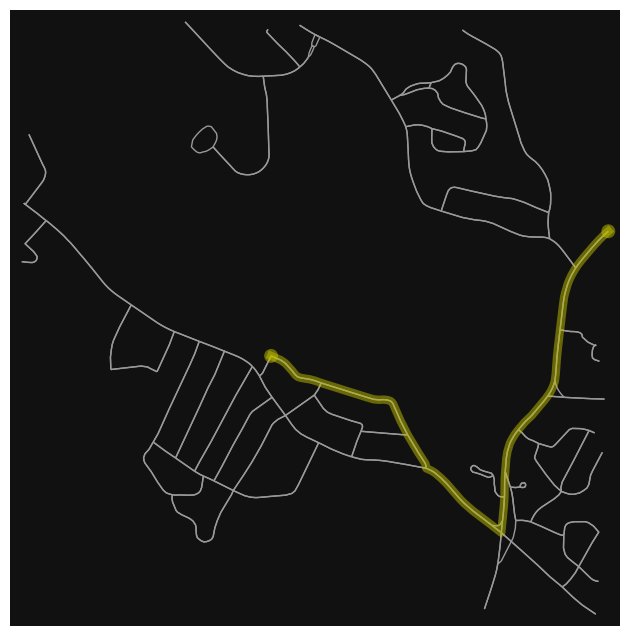

In [10]:
#* NX A* no heuristic = dijkstra's
# Currently weight is length but can be changed to time by changing weight to "travel_time"
astar_shortest_path_list = alg.astar_shortest_path(address_list[0], address_list[1], weight="length")

fig, ax = ox.plot_graph_route(alg.graph, astar_shortest_path_list, route_color="y", route_linewidth=6, node_size=0)